## ECE 848 Final Project - Multiobjective Portfolio Optimization using GA and NSGA-II with modified operators - Aditya Jain

This Python code is part of a comprehensive project aimed at optimizing financial portfolios using multi-objective evolutionary algorithms. The project focuses on the S&P 500 dataset, with the primary goal of constructing an efficient portfolio that balances maximizing returns and minimizing risk. The code encompasses various stages of the project, including data preprocessing, implementation of genetic algorithms with penalty methods and hard constraints, and the application of the NSGA-II algorithm for multi-objective optimization. Additionally, it includes comparative analysis with traditional methods like the Critical Line Algorithm (CLA) to evaluate the effectiveness of evolutionary algorithms in portfolio optimization. This code serves as a practical tool for portfolio managers and personal finance enthusiasts, enabling the construction of robust portfolios using advanced computational techniques.


#### Importing libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import numpy as np
import random
import cvxpy as cp
from deap import base, creator, tools, algorithms
from pymoo.indicators.hv import HV
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, CLA, plotting, objective_functions
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from pymoo.indicators.hv import Hypervolume
import pprint
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#### Reading and preprocessing the data for the GA 

In [2]:
# Read in the S&P 500 dataset:
data0 = pd.read_csv("Dataset/S&P_Stocks.csv")
tickers_sector = pd.read_excel("Dataset/Ticker_sector.xlsx")

# preprocessing
df0 = data0.copy()
df0.loc[:, 'date'] = pd.to_datetime(df0.loc[:, 'date'])
df0 = df0.astype({'Name': 'string'})
tickers_sector.rename(columns={'Ticker': 'Name'}, inplace=True)

merged_df = pd.merge(df0, tickers_sector, on='Name')
merged_df = merged_df.dropna(subset=['Sector'])
df = df0.copy()

# pivoting on closing price of tickers
df_closingPrices = df.pivot(index='date', columns='Name', values='close')
duplicated_rows = df_closingPrices[df_closingPrices.duplicated()]

# missing value treatment
df_closingPrices = df_closingPrices.replace({0: np.nan})

missing_values_count = df_closingPrices.isnull().sum()

df_closingPrices_copy = df_closingPrices.copy()
columns_with_missing_values = df_closingPrices_copy.columns[df_closingPrices_copy.isnull().sum() > 1]
df_closingPrices = df_closingPrices_copy.drop(columns=columns_with_missing_values)

mean_historical = expected_returns.mean_historical_return(df_closingPrices)
capm = expected_returns.capm_return(df_closingPrices)

mean_historical_ranks = mean_historical.rank()
capm_ranks = capm.rank()

### testing ranking method for filtering top 200 tickers, Final choice method 2 as gave the best sharpe ratio outcome
# average_ranks = (mean_historical_ranks) # Method 1
average_ranks = (capm_ranks) # Method 2
# average_ranks = (mean_historical_ranks + capm_ranks) / 2 # Method 3

# Selecting atleast 5 tickers from all sectors to ensure diversity in choice for the GA
sector_counts = merged_df['Sector'].value_counts()
selected_tickers = []

for sector in sector_counts.index:
    sector_tickers = merged_df[merged_df['Sector'] == sector]['Name'].unique()
    
    sector_tickers = [ticker for ticker in sector_tickers if ticker in average_ranks.index]
    
    if sector_tickers:
        sector_ranks = average_ranks[sector_tickers].sort_values()
        selected_tickers.extend(sector_ranks.head(5).index.tolist())

# Fill the rest tickers based on ranking
remaining_tickers = [ticker for ticker in average_ranks.sort_values().index if ticker not in selected_tickers]
selected_tickers.extend(remaining_tickers[:200 - len(selected_tickers)])
selected_tickers

selected_stocks_df = df_closingPrices[selected_tickers]

# adding some gausian noise to the data
gaussian_noise = np.random.normal(0, 1, selected_stocks_df.shape)
forecasted_data = selected_stocks_df + gaussian_noise
forecasted_data.dropna(inplace=True)

#### Implementing GA with penalty functions

In [3]:
# Defining valid boundaries
a = 0
b = 1
filtered_tickers_sector = tickers_sector[tickers_sector['Name'].isin(selected_tickers)]
selected_tickers0 = filtered_tickers_sector['Name'].tolist()

def create_individual():
    individual = []
    for _ in range(50):  # Assuming 50 tickers in each individual, This can be changed later!
        ticker = random.choice(selected_tickers0)
        weight = random.uniform(a, b)  # Random weight
        individual.append((ticker, weight))
    return creator.Individual(individual)


# creating fitness function for maximizing the sharpe ratio
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# defining two point crossover 
def custom_crossover(ind1, ind2):
    size = min(len(ind1), len(ind2))
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: 
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] = ind2[cxpoint1:cxpoint2], ind1[cxpoint1:cxpoint2]

    # Normalize weights for constraints
    for ind in (ind1, ind2):
        weights = np.clip([w for _, w in ind], a, b)
        weights /= np.sum(weights)
        for i in range(50):
            ind[i] = (ind[i][0], weights[i])
            
    return ind1, ind2

def custom_mutation(individual):
    # Randomly change a few tickers and adjust weights
    for _ in range(5):
        ticker_index = random.randrange(50)
        new_ticker = random.choice(selected_tickers0)
        new_weight = random.uniform(a, b)
        individual[ticker_index] = (new_ticker, new_weight)

    weights = np.clip([w for _, w in individual], a, b)
    weights /= np.sum(weights)
    for i in range(50):
        individual[i] = (individual[i][0], weights[i])
    return individual,

# define portfolio evaluation function
def evalPortfolio(individual):
    tickers, weights = zip(*individual)
    weights = np.array(weights)

    # Calculate portfolio performance
    data = forecasted_data[list(tickers)]
    expected_returns_data = expected_returns.capm_return(data)
    cov_matrix = risk_models.CovarianceShrinkage(data).ledoit_wolf()

    ef = EfficientFrontier(expected_returns_data, cov_matrix, weight_bounds=(None, None))
    ef.weights = weights
    sharpe_ratio = ef.portfolio_performance()[2]

    # Initialize penalty
    penalty = 0

    # Add a check for tickers in tickers_sector
    valid_tickers = filtered_tickers_sector['Name'].unique()

    # Penalty for individual ticker weights
    min_weight, max_weight = 0.001, 0.05  # 0.1% to 5%
    for weight in weights:
        if weight < min_weight or weight > max_weight:
            penalty += abs(weight - min_weight) if weight < min_weight else abs(weight - max_weight)

    # Penalty for total number of tickers
    if len(individual) != 50:
        penalty += abs(50 - len(individual))

    # Penalty for sum of weights not equal to 1
    if not np.isclose(np.sum(weights), 1.0):
        penalty += abs(np.sum(weights) - 1.0)

    sector_ticker_count = {sector: 0 for sector in sector_counts.index}
    for ticker, _ in individual:
        sector_query = filtered_tickers_sector.loc[filtered_tickers_sector['Name'] == ticker, 'Sector']
        if not sector_query.empty:
            sector = sector_query.iloc[0]
            sector_ticker_count[sector] += 1
        else:
            penalty += 10

    for count in sector_ticker_count.values():
        if count < 2:
            penalty += abs(2 - count)

    # Penalty for sector allocation constraint violation
    min_sector_weight, max_sector_weight = 0.03, 0.15  # 3% to 15%
    sector_allocation = {}
    for ticker, weight in individual:
        sector = filtered_tickers_sector.loc[filtered_tickers_sector['Name'] == ticker, 'Sector'].iloc[0]
        sector_allocation[sector] = sector_allocation.get(sector, 0) + weight

    for sector_weight in sector_allocation.values():
        if sector_weight < min_sector_weight or sector_weight > max_sector_weight:
            penalty += abs(sector_weight - min_sector_weight) if sector_weight < min_sector_weight else abs(sector_weight - max_sector_weight)

    # Apply penalty to the fitness score
    return (sharpe_ratio - penalty,)


toolbox.register("evaluate", evalPortfolio)
toolbox.register("mate", custom_crossover)
toolbox.register("mutate", custom_mutation)
toolbox.register("select", tools.selTournament, tournsize=3)

# Lists to store fitness statistics
best_fitness_per_generation = []
average_fitness_per_generation = []
fitness_matrix = []

# Running the genetic algorithm
population = toolbox.population(n=100)
NGEN = 100

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the population
    population = toolbox.select(offspring, k=len(population))

    # Extracting fitness values
    generation_fitness = [ind.fitness.values[0] for ind in population]
    best_fitness = max(generation_fitness)
    average_fitness = sum(generation_fitness) / len(generation_fitness)

    # Append to the lists
    best_fitness_per_generation.append(best_fitness)
    average_fitness_per_generation.append(average_fitness)
    fitness_matrix.append(generation_fitness)

top_individual = tools.selBest(population, k=1)[0]

print("Optimized Portfolio:")
for ticker, weight in top_individual:
    print(f"{ticker}: {weight:.2%}")

Optimized Portfolio:
CHTR: 2.62%
AAPL: 2.41%
DTE: 0.49%
CLX: 0.64%
SJM: 0.80%
BDX: 3.49%
EXR: 1.49%
PPL: 1.76%
DRI: 2.66%
SNPS: 1.33%
EQT: 3.63%
MO: 1.57%
UNH: 2.46%
TDG: 1.19%
STZ: 1.88%
TRV: 2.12%
CMCSA: 3.20%
CINF: 3.00%
CHRW: 2.22%
FE: 2.13%
ORLY: 0.15%
CCI: 1.07%
AZO: 2.12%
DIS: 2.89%
NI: 2.14%
GD: 2.83%
MNST: 1.73%
PNW: 1.93%
EXC: 2.72%
AAPL: 2.93%
TSN: 1.60%
XOM: 0.76%
PCG: 2.76%
PGR: 1.38%
IRM: 2.53%
NOC: 0.96%
KR: 2.90%
FRT: 3.76%
CB: 2.28%
SHW: 2.92%
JNJ: 2.49%
MCD: 2.70%
HUM: 2.19%
CHD: 0.14%
SHW: 0.69%
UDR: 1.88%
KO: 1.93%
HUM: 1.65%
D: 1.10%
STZ: 1.78%


#### Visualising best and average individual performance of the GA over generations

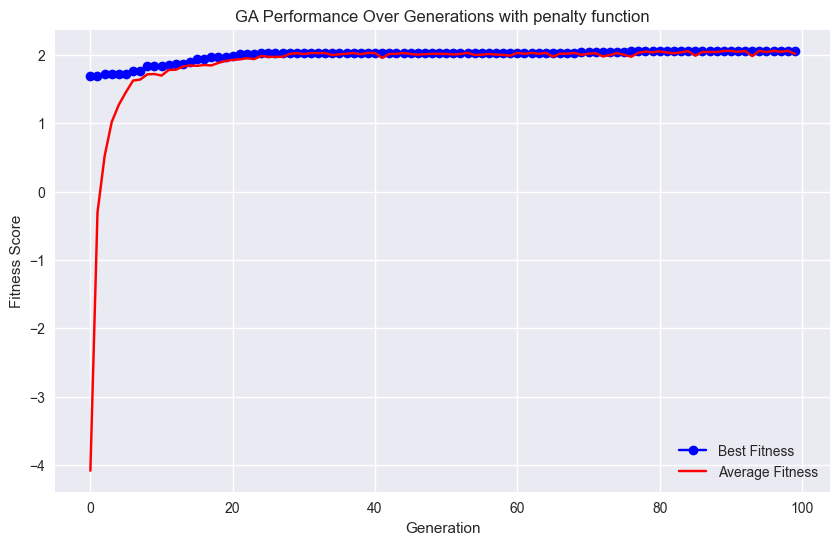

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(best_fitness_per_generation, marker='o', color='b', label='Best Fitness')
plt.plot(average_fitness_per_generation, marker='x', color='r', label='Average Fitness')
plt.title('GA Performance Over Generations with penalty function')
plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.legend()
plt.grid(True)
plt.show()

#### Visualizing sector allocation of the best individual generated using GA

In [5]:

sector_weightage = {sector: 0 for sector in sector_counts.index}
sector_ticker_count = {sector: 0 for sector in sector_counts.index}
for ticker, weight in top_individual:
    sector = tickers_sector.loc[tickers_sector['Name'] == ticker, 'Sector'].iloc[0]
    sector_weightage[sector] += weight
    sector_ticker_count[sector] += 1

for sector in sector_weightage:
    sector_weightage[sector] *= 100

df = pd.DataFrame({'Sector': list(sector_weightage.keys()), 
                   'Weightage (%)': list(sector_weightage.values()), 
                   'Ticker Count': list(sector_ticker_count.values())})

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=df['Weightage (%)'],
      theta=df['Sector'],
      fill='toself',
      name='Sector Weightage (%)'
))

fig.add_trace(go.Scatterpolar(
      r=df['Ticker Count'],
      theta=df['Sector'],
      fill='toself',
      name='Number of Tickers'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(df['Weightage (%)'].max(), df['Ticker Count'].max())]
        )),
    showlegend=True,
    autosize=False,
    title="Sector Analysis of Optimized Portfolio using penalty function: Weightage and Ticker Count",
    width=700,  
    height=500 
)

fig.show()


#### Calculating expected return, volatility and sharpe ratio of the best individual from GA

In [6]:
tickers, weights = zip(*top_individual)
weights = np.array(weights)

data = forecasted_data[list(tickers)]

expected_returns_data = expected_returns.capm_return(data)
cov_matrix = risk_models.CovarianceShrinkage(data).ledoit_wolf()

ef = EfficientFrontier(expected_returns_data, cov_matrix, weight_bounds=(None, None))
ef.weights = weights
performance = ef.portfolio_performance(verbose=True)


Expected annual return: 27.7%
Annual volatility: 12.5%
Sharpe Ratio: 2.06


#### Implementing GA with hard constraints 

In [7]:
a = 0.001  # Lower bound
b = 0.05  # Upper bound
MIN_SECTOR_WEIGHT = 0.03  # 3%
MAX_SECTOR_WEIGHT = 0.15  # 15%
NUM_TICKERS = 50

# creating fitness function for maximizing the sharpe ratio
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

def create_individual_hard_constraints():
    individual = []
    sector_ticker_count = {sector: 0 for sector in sector_counts.index}
    sector_weights = {sector: 0 for sector in sector_counts.index}

    # First, ensure at least two tickers from each sector by randonly selecting tickers for initialization for sector constraint
    for sector in sector_counts.index:
        sector_tickers = [t for t in selected_tickers if t in tickers_sector['Name'].values and tickers_sector.loc[tickers_sector['Name'] == t, 'Sector'].iloc[0] == sector]
        selected_from_sector = random.sample(sector_tickers, min(2, len(sector_tickers)))
        for ticker in selected_from_sector:
            individual.append((ticker, 0)) 
            sector_ticker_count[sector] += 1

    # Fill the rest of the individual with random tickers
    while len(individual) < 50:
        ticker = random.choice(selected_tickers)
        if ticker not in tickers_sector['Name'].values:
            continue  
        sector = tickers_sector.loc[tickers_sector['Name'] == ticker, 'Sector'].iloc[0]
        if sector_ticker_count[sector] < 2:
            continue  
        individual.append((ticker, 0))
        sector_ticker_count[sector] += 1

    # Assign random weights initially
    weights = np.random.uniform(a, b, len(individual))
    weights /= np.sum(weights)

    # Assign weights to individual and update sector weights
    for i, (ticker, _) in enumerate(individual):
        sector = tickers_sector.loc[tickers_sector['Name'] == ticker, 'Sector'].iloc[0]
        individual[i] = (ticker, weights[i])
        sector_weights[sector] += weights[i]

    # Adjust weights to meet sector constraints
    for sector, weight in sector_weights.items():
        sector_tickers = [(i, ticker, w) for i, (ticker, w) in enumerate(individual) if tickers_sector.loc[tickers_sector['Name'] == ticker, 'Sector'].iloc[0] == sector]
        
        if weight < MIN_SECTOR_WEIGHT:
            # Increase weight for this sector
            max_weight_ticker = max(sector_tickers, key=lambda x: x[2])
            additional_weight = MIN_SECTOR_WEIGHT - weight
            individual[max_weight_ticker[0]] = (max_weight_ticker[1], max_weight_ticker[2] + additional_weight)
        elif weight > MAX_SECTOR_WEIGHT:
            # Decrease weight for this sector
            max_weight_ticker = max(sector_tickers, key=lambda x: x[2])
            excess_weight = weight - MAX_SECTOR_WEIGHT
            individual[max_weight_ticker[0]] = (max_weight_ticker[1], max_weight_ticker[2] - excess_weight)

    # Normalize weights to sum up to 1
    total_weight = sum([w for _, w in individual])
    individual = [(ticker, weight / total_weight) for ticker, weight in individual]

    return creator.Individual(individual)


toolbox.register("individual", create_individual_hard_constraints)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# defining two point crossover 
def custom_crossover_hard_constraints(ind1, ind2):
    size = min(len(ind1), len(ind2))
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: 
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] = ind2[cxpoint1:cxpoint2], ind1[cxpoint1:cxpoint2]

    # Normalize weights for constraints
    for ind in (ind1, ind2):
        weights = np.clip([w for _, w in ind], a, b)
        weights /= np.sum(weights)
        for i in range(50):
            ind[i] = (ind[i][0], weights[i])
    return ind1, ind2

def custom_mutation_hard_constraints(individual):
    # Randomly change five ticker and adjust weights
    for i in range(5):
        ticker_index = random.randrange(50)
        old_ticker = individual[ticker_index][0]
        old_sector = tickers_sector.loc[tickers_sector['Name'] == old_ticker, 'Sector'].iloc[0]

        # Count tickers in each sector to ensure sector constraint
        sector_ticker_count = {sector: 0 for sector in sector_counts.index}
        for ticker, _ in individual:
            if ticker in tickers_sector['Name'].values:
                sector = tickers_sector.loc[tickers_sector['Name'] == ticker, 'Sector'].iloc[0]
                sector_ticker_count[sector] += 1

        # Ensure new ticker maintains sector constraint
        while True:
            new_ticker = random.choice(selected_tickers)
            if new_ticker not in tickers_sector['Name'].values:
                continue  # Skip if new ticker is not satisfies
            new_sector = tickers_sector.loc[tickers_sector['Name'] == new_ticker, 'Sector'].iloc[0]
            if new_sector == old_sector or sector_ticker_count[new_sector] < 2:
                individual[ticker_index] = (new_ticker, individual[ticker_index][1])
                break

        # Normalize weights
        weights = np.clip([w for _, w in individual], a, b)
        weights /= np.sum(weights)
        for i in range(50):
            individual[i] = (individual[i][0], weights[i])
    return individual,

def evalPortfolio_hard_constraints(individual):
    tickers, weights = zip(*individual)
    weights = np.array(weights)

    # Calculate portfolio performance
    data = forecasted_data[list(tickers)]
    expected_returns_data = expected_returns.capm_return(data)
    cov_matrix = risk_models.CovarianceShrinkage(data).ledoit_wolf()

    ef = EfficientFrontier(expected_returns_data, cov_matrix, weight_bounds=(None, None))
    ef.weights = weights
    sharpe_ratio = ef.portfolio_performance()[2]

    # Calculate sector-wise allocation
    sector_allocation = {}
    for ticker, weight in individual:
        sector = tickers_sector.loc[tickers_sector['Name'] == ticker, 'Sector'].iloc[0]
        sector_allocation[sector] = sector_allocation.get(sector, 0) + weight

    return (sharpe_ratio,)  # Return a tuple


toolbox.register("individual", create_individual_hard_constraints)
toolbox.register("mate", custom_crossover_hard_constraints)
toolbox.register("mutate", custom_mutation_hard_constraints)
toolbox.register("evaluate", evalPortfolio_hard_constraints)
toolbox.register("select", tools.selTournament, tournsize=3)

# Lists to store fitness statistics
best_fitness_per_generation = []
average_fitness_per_generation = []
fitness_matrix = []

# Running the genetic algorithm
population = toolbox.population(n=100)
NGEN = 100

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the population
    population = toolbox.select(offspring, k=len(population))

    # Extracting fitness values
    generation_fitness = [ind.fitness.values[0] for ind in population]
    best_fitness = max(generation_fitness)
    average_fitness = sum(generation_fitness) / len(generation_fitness)

    # Append to the lists
    best_fitness_per_generation.append(best_fitness)
    average_fitness_per_generation.append(average_fitness)
    fitness_matrix.append(generation_fitness)

top_individual = tools.selBest(population, k=1)[0]

print("Optimized Portfolio:")
for ticker, weight in top_individual:
    print(f"{ticker}: {weight:.2%}")

Optimized Portfolio:
SBUX: 1.43%
ULTA: 2.90%
LMT: 0.75%
GD: 2.95%
CBOE: 3.06%
CBOE: 1.31%
HOLX: 2.56%
CI: 1.17%
SNPS: 2.76%
AAPL: 3.20%
TSN: 2.45%
DG: 1.89%
IRM: 2.92%
SBAC: 1.38%
NI: 2.74%
CMS: 2.49%
SLB: 1.68%
CVX: 2.78%
CHTR: 0.60%
CMCSA: 2.31%
NEM: 2.52%
SHW: 0.51%
STZ: 2.04%
SHW: 2.17%
LMT: 1.42%
CME: 2.95%
HRL: 2.96%
IDXX: 1.73%
STZ: 1.24%
KR: 1.34%
STZ: 2.28%
NOC: 1.30%
PGR: 1.04%
RSG: 1.71%
ROST: 2.31%
CHTR: 0.17%
HAS: 3.28%
TSN: 2.31%
ROST: 2.60%
LNT: 1.98%
EW: 1.28%
CBOE: 2.38%
CI: 2.22%
STZ: 2.20%
ORLY: 3.52%
PPL: 0.40%
UNH: 1.61%
MNST: 1.18%
NOC: 2.31%
NOC: 1.70%


#### Visualising best and average individual performance of the GA over generations

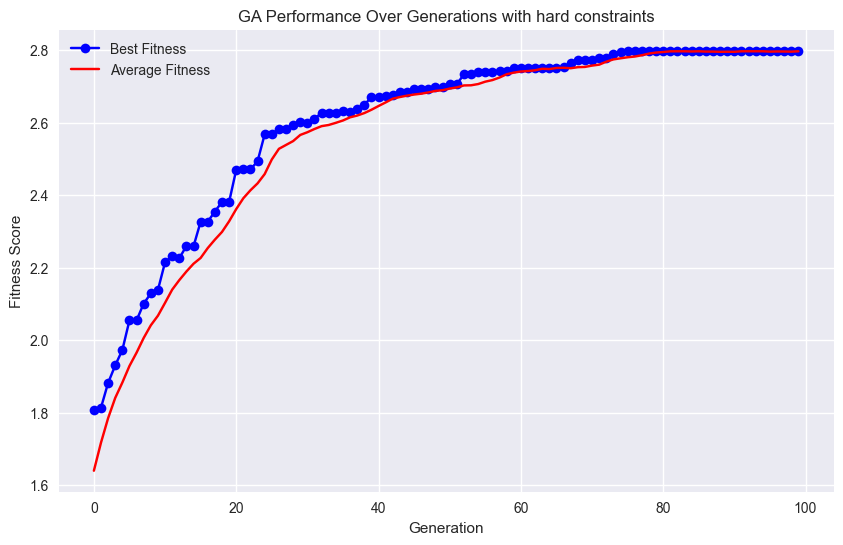

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(best_fitness_per_generation, marker='o', color='b', label='Best Fitness')
plt.plot(average_fitness_per_generation, marker='x', color='r', label='Average Fitness')
plt.title('GA Performance Over Generations with hard constraints')
plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.legend()
plt.grid(True)
plt.show()

#### Visualizing sector allocation of the best individual generated using GA

In [9]:
sector_weightage = {sector: 0 for sector in sector_counts.index}
sector_ticker_count = {sector: 0 for sector in sector_counts.index}
for ticker, weight in top_individual:
    sector = tickers_sector.loc[tickers_sector['Name'] == ticker, 'Sector'].iloc[0]
    sector_weightage[sector] += weight
    sector_ticker_count[sector] += 1

for sector in sector_weightage:
    sector_weightage[sector] *= 100

df = pd.DataFrame({'Sector': list(sector_weightage.keys()), 
                   'Weightage (%)': list(sector_weightage.values()), 
                   'Ticker Count': list(sector_ticker_count.values())})

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=df['Weightage (%)'],
      theta=df['Sector'],
      fill='toself',
      name='Sector Weightage (%)'
))

fig.add_trace(go.Scatterpolar(
      r=df['Ticker Count'],
      theta=df['Sector'],
      fill='toself',
      name='Number of Tickers'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(df['Weightage (%)'].max(), df['Ticker Count'].max())]
        )),
    showlegend=True,
    autosize=False,
    title="Sector Analysis of Optimized Portfolio with hard constraints: Weightage and Ticker Count",
    width=700,  
    height=500 
)

fig.show()


#### Calculating expected return, volatility and sharpe ratio of the best individual from GA

In [10]:
tickers, weights = zip(*top_individual)
weights = np.array(weights)

data = forecasted_data[list(tickers)]

expected_returns_data = expected_returns.capm_return(data)
cov_matrix = risk_models.CovarianceShrinkage(data).ledoit_wolf()

ef = EfficientFrontier(expected_returns_data, cov_matrix, weight_bounds=(None, None))
ef.weights = weights
performance = ef.portfolio_performance(verbose=True)


Expected annual return: 39.1%
Annual volatility: 13.3%
Sharpe Ratio: 2.80


### Sector wise and ticker wise allocations

In [11]:
# Extract tickers and weights from the top individual
tickers_weights = [(ticker, weight) for ticker, weight in top_individual]

# Map tickers to sectors and calculate sector-wise weight allocation
sector_allocation = {}
for ticker, weight in tickers_weights:
    sector = tickers_sector.loc[tickers_sector['Name'] == ticker, 'Sector'].iloc[0]
    if sector in sector_allocation:
        sector_allocation[sector] += weight
    else:
        sector_allocation[sector] = weight

sector_df = pd.DataFrame(list(sector_allocation.items()), columns=['Sector', 'Total Weight'])

print("Sector-wise Distribution:")
print(sector_df)


Sector-wise Distribution:
                    Sector  Total Weight
0        Consumer Cyclical      0.160379
1              Industrials      0.121496
2       Financial Services      0.107386
3               Healthcare      0.105655
4               Technology      0.059574
5       Consumer Defensive      0.198888
6              Real Estate      0.042948
7                Utilities      0.076134
8                   Energy      0.044618
9   Communication Services      0.030896
10         Basic Materials      0.052027


In [12]:
sector_ticker_dfs = []

for sector in sector_counts.index:
    tickers_in_sector = [(ticker, weight) for ticker, weight in tickers_weights if tickers_sector.loc[tickers_sector['Name'] == ticker, 'Sector'].iloc[0] == sector]
    if tickers_in_sector:
        df = pd.DataFrame(tickers_in_sector, columns=['Ticker', 'Weight'])
        df['Sector'] = sector
        sector_ticker_dfs.append(df)

all_sectors_df = pd.concat(sector_ticker_dfs)

print("\nIndividual Ticker Allocation:")
print(all_sectors_df)



Individual Ticker Allocation:
  Ticker    Weight                  Sector
0   SBUX  0.014336       Consumer Cyclical
1   ULTA  0.028970       Consumer Cyclical
2   ROST  0.023086       Consumer Cyclical
3    HAS  0.032837       Consumer Cyclical
4   ROST  0.025975       Consumer Cyclical
5   ORLY  0.035174       Consumer Cyclical
0    LMT  0.007455             Industrials
1     GD  0.029458             Industrials
2    LMT  0.014232             Industrials
3    NOC  0.013038             Industrials
4    RSG  0.017137             Industrials
5    NOC  0.023136             Industrials
6    NOC  0.017040             Industrials
0   CBOE  0.030604      Financial Services
1   CBOE  0.013111      Financial Services
2    CME  0.029467      Financial Services
3    PGR  0.010448      Financial Services
4   CBOE  0.023757      Financial Services
0   HOLX  0.025587              Healthcare
1     CI  0.011711              Healthcare
2   IDXX  0.017326              Healthcare
3     EW  0.012811     

#### Comparision to CLA method (unconstrained QP method for multiobjective portfolio optimization)

Expected annual return: 38.3%
Annual volatility: 12.8%
Sharpe Ratio: 2.84
Optimized Weights: OrderedDict([('SBUX', 0.02025), ('ULTA', 0.02091), ('LMT', 0.0), ('GD', 0.02388), ('CBOE', 0.0), ('HOLX', 0.01947), ('CI', 0.0), ('SNPS', 0.02074), ('AAPL', 0.02232), ('TSN', 0.0), ('DG', 0.02087), ('IRM', 0.02007), ('SBAC', 0.02214), ('NI', 0.02004), ('CMS', 0.02036), ('SLB', 0.0211), ('CVX', 0.02158), ('CHTR', 0.02094), ('CMCSA', 0.01967), ('NEM', 0.01994), ('SHW', 0.0), ('STZ', 0.0), ('CME', 0.02254), ('HRL', 0.01981), ('IDXX', 0.02159), ('KR', 0.01983), ('NOC', 0.0), ('PGR', 0.01992), ('RSG', 0.02047), ('ROST', 0.0), ('HAS', 0.0208), ('LNT', 0.0198), ('EW', 0.02056), ('ORLY', 0.02251), ('PPL', 0.02011), ('UNH', 0.02324), ('MNST', 0.02017)])

Sector-wise Allocation Percentages:
                         Weight
Sector                         
Basic Materials         0.01994
Communication Services  0.04061
Consumer Cyclical       0.08447
Consumer Defensive      0.08068
Energy                  0

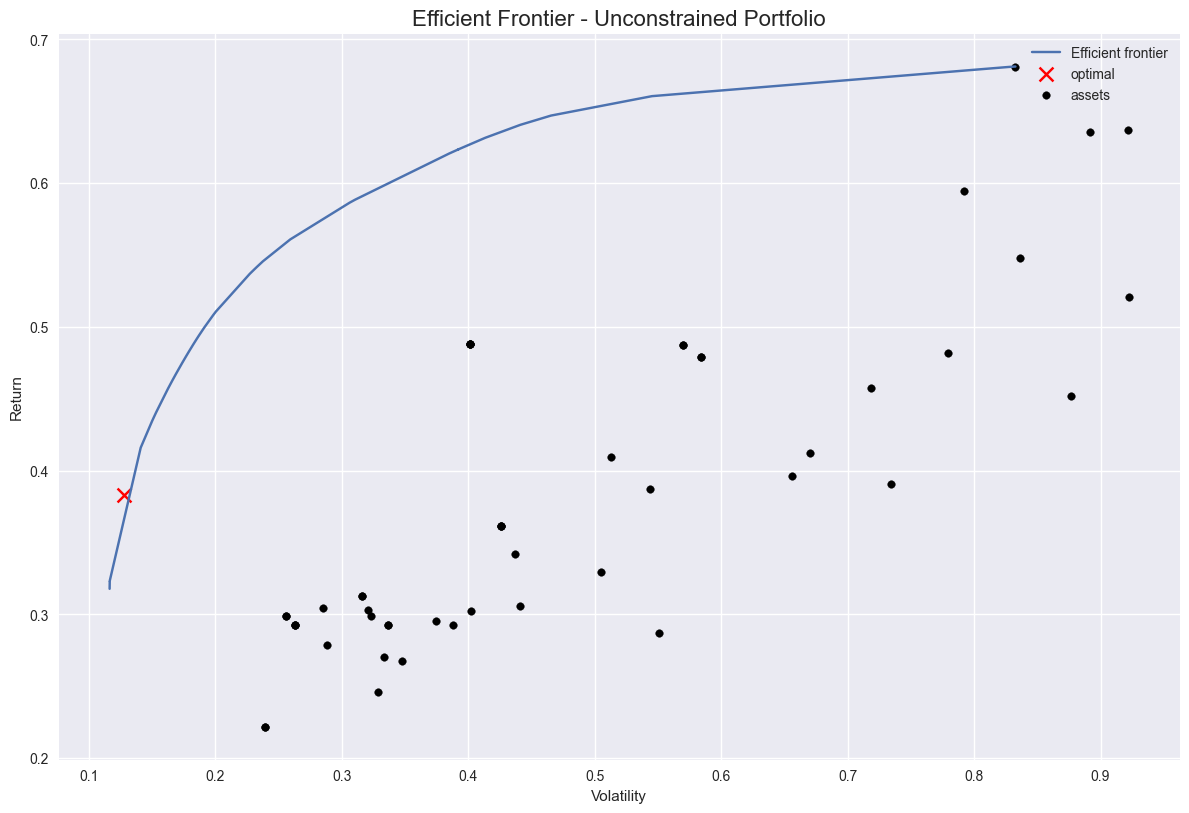

In [13]:
tickers = [ticker for ticker, _ in top_individual]

if all(ticker in forecasted_data.columns for ticker in tickers):
    cla_data = forecasted_data[tickers]

    exp_returns = expected_returns.capm_return(cla_data)
    covariance = risk_models.CovarianceShrinkage(cla_data).ledoit_wolf()

    cla = CLA(exp_returns, covariance)
    cla.max_sharpe()
    cla.portfolio_performance(verbose=True)

    # Extract optimized weights
    optimized_weights = cla.clean_weights()
    print("Optimized Weights:", optimized_weights)

    # Create DataFrame for tickers, sectors, and weights
    allocation_df = pd.DataFrame(list(optimized_weights.items()), columns=['Ticker', 'Weight'])
    allocation_df['Sector'] = allocation_df['Ticker'].apply(lambda x: tickers_sector.loc[tickers_sector['Name'] == x, 'Sector'].iloc[0])

    sector_allocation_percent = pd.pivot_table(allocation_df, values='Weight', index=['Sector'], aggfunc=sum)

    sector_ticker_count = allocation_df.groupby('Sector')['Ticker'].count()

    print("\nSector-wise Allocation Percentages:")
    print(sector_allocation_percent)

    print("\nCount of Tickers in Each Sector:")
    print(sector_ticker_count)

    plt.figure(figsize=(12,8))
    ax = plotting.plot_efficient_frontier(cla, showfig=False)
    ax.set_title('Efficient Frontier - Unconstrained Portfolio', fontsize=16)
    plt.show()

else:
    print("One or more tickers are not in the DataFrame columns.")

#### Definining operatiors for multiobjective optimization using NSGA-II on top individual generated using GA
#### Implementing NSGA-II with penalty functions

In [14]:
a = 0
b = 1
filtered_tickers_sector = tickers_sector[tickers_sector['Name'].isin(selected_tickers)]
selected_tickers0 = filtered_tickers_sector['Name'].tolist()

creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))  # Maximize return, minimize risk
creator.create("Individual", list, fitness=creator.FitnessMulti)
MUTATION_PROB = 0.1

# Initialize individual population members
def multi_individual():
    individual = []
    for _ in range(50):  # Assuming 50 tickers in each individual
        ticker = random.choice(selected_tickers0)
        weight = random.uniform(a, b)  # Random weight
        individual.append((ticker, weight))
    return creator.Individual(individual)

# mutation function for mutating weights for ticker allocation
def multi_mutation(individual):
    # Gaussian mutation for weights
    for i in range(len(individual)):
        if random.random() < MUTATION_PROB:
            individual[i] = (individual[i][0], individual[i][1] + np.random.normal(0, 0.1))  # Adjust 0.01 as needed

    # Normalize weights after mutation
    total_weight = sum([w for _, w in individual])
    individual[:] = [(ticker, weight / total_weight) for ticker, weight in individual]

    return (individual,)

# Evaluation function for multi objective performance
def multievalPortfolio(individual):
    tickers, weights = zip(*individual)
    weights = np.array(weights)

    # Calculate portfolio performance
    data = forecasted_data[list(tickers)]
    expected_returns_data = expected_returns.capm_return(data)
    cov_matrix = risk_models.CovarianceShrinkage(data).ledoit_wolf()
    ef = EfficientFrontier(expected_returns_data, cov_matrix, weight_bounds=(0, 1))
    ef.weights = weights
    portfolio_performance = ef.portfolio_performance()

    # Initialize penalty
    penalty = 0

    # Add a check for tickers in tickers_sector
    valid_tickers = filtered_tickers_sector['Name'].unique()

    # Penalty for individual ticker weights
    min_weight, max_weight = 0.001, 0.05  # 0.1% to 5%
    for weight in weights:
        if weight < min_weight or weight > max_weight:
            penalty += abs(weight - min_weight) if weight < min_weight else abs(weight - max_weight)

    # Penalty for sum of weights not equal to 1
    if not np.isclose(np.sum(weights), 1.0):
        penalty += abs(np.sum(weights) - 1.0)

    sector_ticker_count = {sector: 0 for sector in sector_counts.index}
    for ticker, _ in individual:
        sector_query = filtered_tickers_sector.loc[filtered_tickers_sector['Name'] == ticker, 'Sector']
        if not sector_query.empty:
            sector = sector_query.iloc[0]
            sector_ticker_count[sector] += 1
        else:
            penalty += 1

    for count in sector_ticker_count.values():
        if count < 2:
            penalty += abs(2 - count)

    # Penalty for sector allocation constraint violation
    min_sector_weight, max_sector_weight = 0.03, 0.15  # 3% to 15%
    sector_allocation = {}
    for ticker, weight in individual:
        sector = filtered_tickers_sector.loc[filtered_tickers_sector['Name'] == ticker, 'Sector'].iloc[0]
        sector_allocation[sector] = sector_allocation.get(sector, 0) + weight

    for sector_weight in sector_allocation.values():
        if sector_weight < min_sector_weight or sector_weight > max_sector_weight:
            penalty += abs(sector_weight - min_sector_weight) if sector_weight < min_sector_weight else abs(sector_weight - max_sector_weight)

    # Apply penalty to the fitness score
    return portfolio_performance[0] -penalty , portfolio_performance[1]


toolbox0 = base.Toolbox()
toolbox0.register("individual", multi_individual)
toolbox0.register("population", tools.initRepeat, list, toolbox0.individual)
toolbox0.register("evaluate", multievalPortfolio)
toolbox0.register("mate", custom_crossover)
toolbox0.register("mutate", multi_mutation)
toolbox0.register("select", tools.selNSGA2)

# Function to run NSGA-II algorithm and return logbook
def run_NSGA2(population_size, ngen, toolbox):
    population = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    pop, logbook = algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=population_size, 
                              cxpb=0.5, mutpb=0.2, ngen=ngen, stats=stats, halloffame=hof, verbose=True)

    return pop, logbook, hof


NUM_RUNS = 5
population_size = 50
ngen = 100

all_runs_results = []
all_runs_hof = []
all_runs_stats = []
all_runs_times = []
all_generations_hv = []

for run in range(NUM_RUNS):
    print(f"Running NSGA-II: Run {run + 1}/{NUM_RUNS}")
    start_time = time.time()
    pop, logbook, hof = run_NSGA2(population_size, ngen, toolbox0)
    end_time = time.time()
    run_time = end_time - start_time
    print(f"Run {run + 1} completed in {run_time:.2f} seconds")

    all_runs_results.append(pop)
    all_runs_hof.append(hof)
    all_runs_stats.append(logbook)
    all_runs_times.append(run_time)

    # Calculate Hypervolume for each generation
    gen_hv = []
    ref_point = np.array([0, 0.3])  # Adjust according to your objectives
    hv = HV(ref_point=ref_point)
    for gen_num in range(ngen):
        fitnesses = np.array([ind.fitness.values for ind in pop])
        hv_value = hv.do(fitnesses)
        gen_hv.append(hv_value)
    all_generations_hv.append(gen_hv)

Running NSGA-II: Run 1/5
gen	nevals	avg                        	std                    	min                        	max                        
0  	50    	[-67.53495715   3.19044986]	[5.54949838 0.28791464]	[-79.77168347   2.55570228]	[-53.17053905   3.86986808]
1  	29    	[-27.39206241   1.26760031]	[28.22746232  1.34350202]	[-65.44351966   0.11715934]	[-0.8286691   3.16182853]  
2  	36    	[-2.83948833  0.12789625]  	[1.19863406 0.00656411]  	[-5.0189485   0.11715934]  	[-0.8286691   0.14752489]  
3  	37    	[-2.66247601  0.12533261]  	[1.30642487 0.00412394]  	[-5.87843529  0.11715934]  	[0.03829972 0.13843983]    
4  	35    	[-2.13563512  0.12488858]  	[1.28576306 0.00487544]  	[-5.0189485   0.11715934]  	[0.03829972 0.13843983]    
5  	31    	[-1.60057816  0.12398757]  	[0.98747782 0.00460344]  	[-3.91820575  0.11715934]  	[0.1318991  0.13631578]    
6  	37    	[-1.33495623  0.12274409]  	[1.23345864 0.00455995]  	[-3.95516904  0.11462732]  	[0.20397968 0.13446408]    
7  	38    	

Average run time: 165.74 seconds


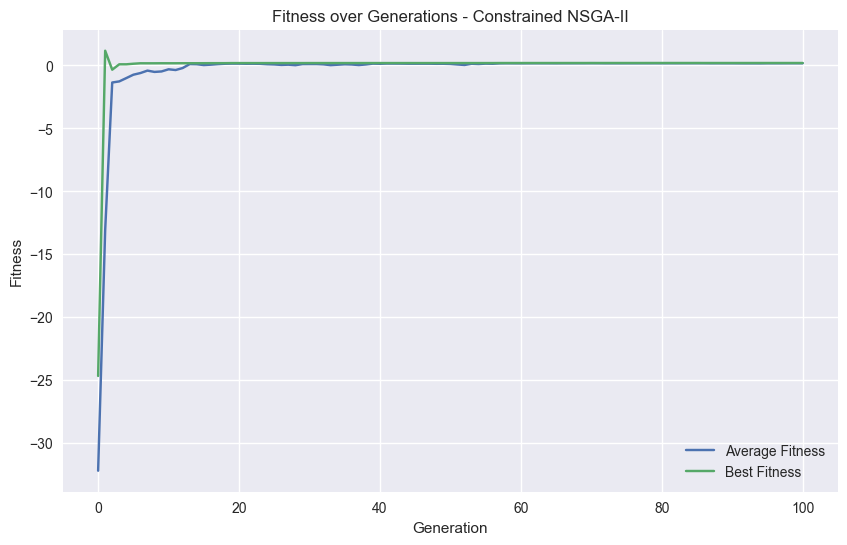

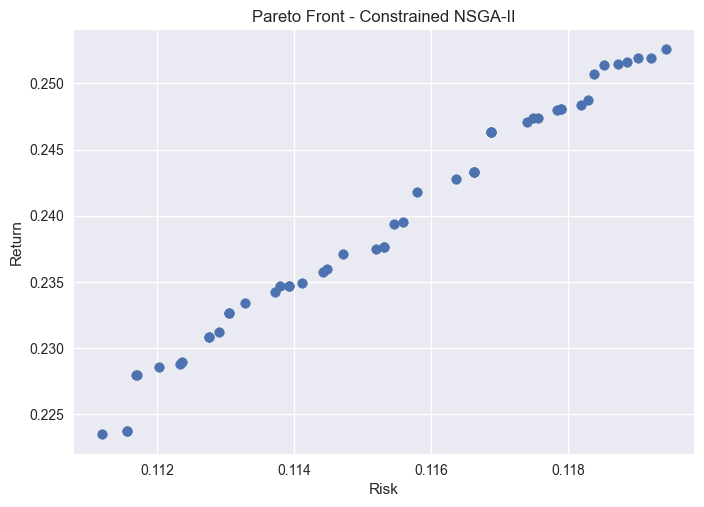

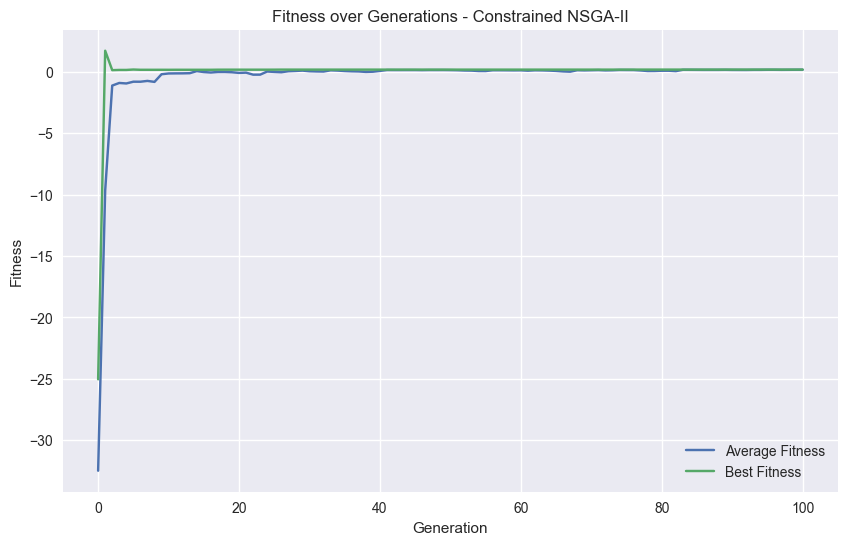

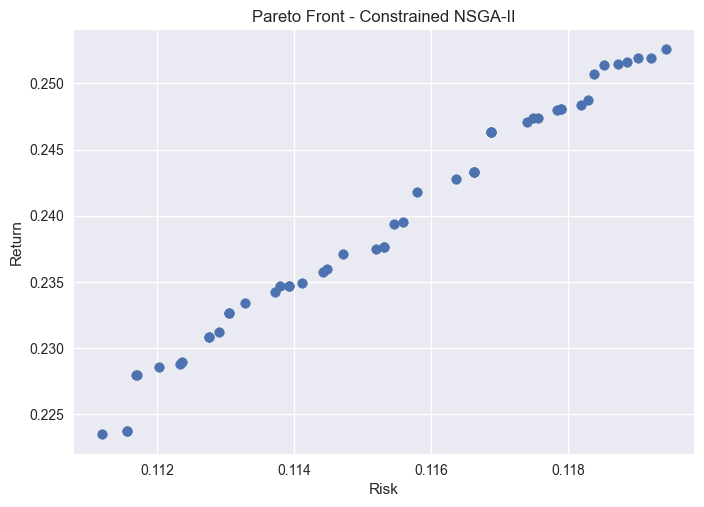

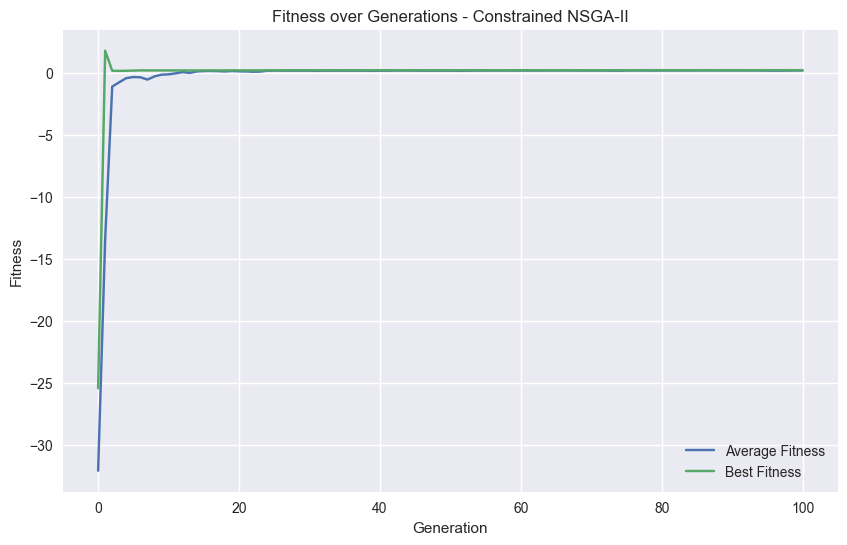

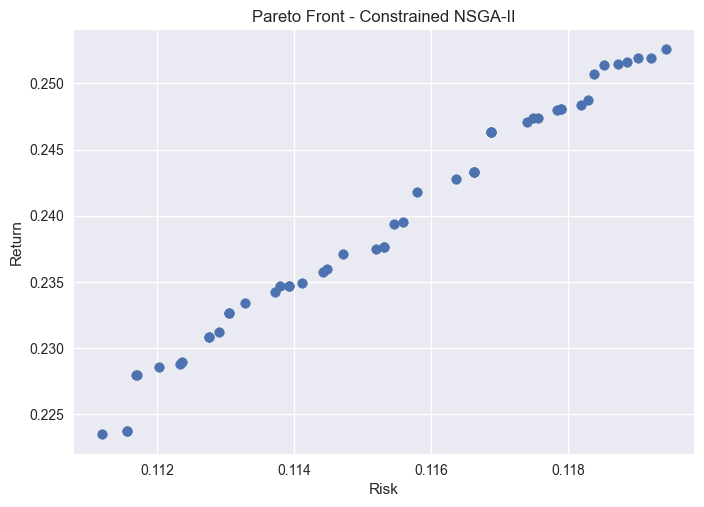

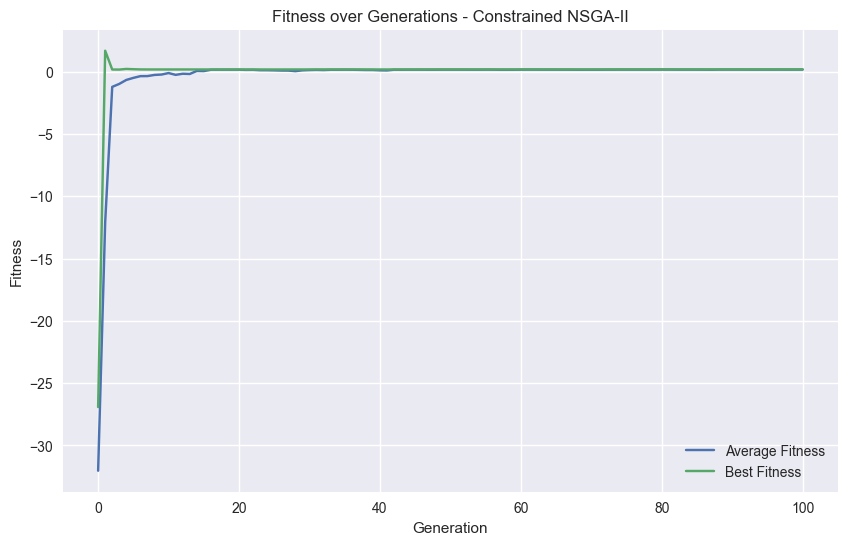

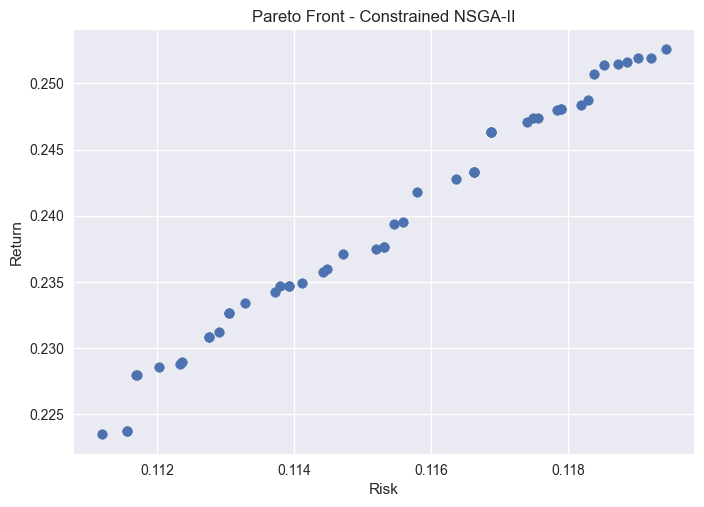

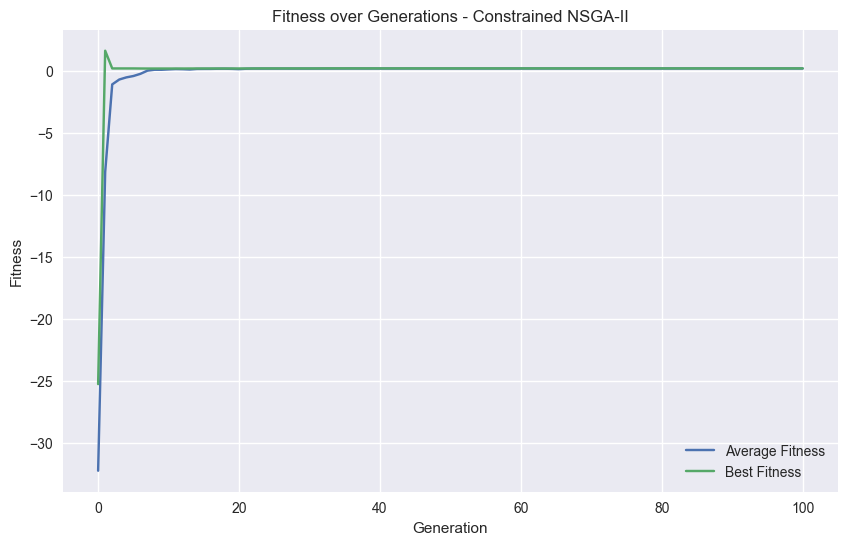

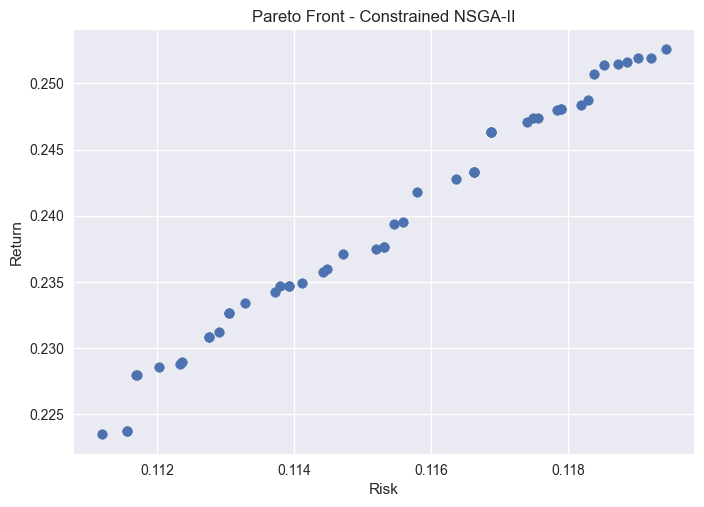

In [15]:
# Calculate average run time
avg_run_time = np.mean(all_runs_times)
print(f"Average run time: {avg_run_time:.2f} seconds")

for run in range(NUM_RUNS):
    gen = range(0, len(all_runs_stats[run]))
    avg_fitness = [np.mean(stat["avg"]) for stat in all_runs_stats[run]]  
    max_fitness = [np.mean(stat["max"]) for stat in all_runs_stats[run]] 

    plt.figure(figsize=(10, 6))
    plt.plot(gen, avg_fitness, label='Average Fitness')
    plt.plot(gen, max_fitness, label='Best Fitness')
    plt.title(f'Fitness over Generations - Constrained NSGA-II')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.show()

    # Plotting Pareto Front
    min_return = 0.1  # Set your minimum return value
    max_return = 1  # Set your maximum return value
    min_risk = 0    # Set your minimum risk value
    max_risk = 0.5    # Set your maximum risk value

    pareto_front = tools.sortNondominated(pop, len(pop), first_front_only=True)[0]
    filtered_pareto_front = [ind for ind in pareto_front if min_return <= ind.fitness.values[0] <= max_return and min_risk <= ind.fitness.values[1] <= max_risk]

    filtered_returns = [ind.fitness.values[0] for ind in filtered_pareto_front]
    filtered_risks = [ind.fitness.values[1] for ind in filtered_pareto_front]

    plt.scatter(filtered_risks, filtered_returns)
    plt.title(f"Pareto Front - Constrained NSGA-II")
    plt.xlabel("Risk")
    plt.ylabel("Return")
    plt.show()


#### Implementing NSGA-II with combination of hard constraints and penalty function in search for global optimum

In [14]:
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))  # Maximize return, minimize risk
creator.create("Individual", list, fitness=creator.FitnessMulti)
MUTATION_PROB = 0.1
a = 0.001  # Lower bound
b = 0.05  # Upper bound

# Initialize individual population members
def multi_individual():
    individual = []
    sector_ticker_count = {sector: 0 for sector in sector_counts.index}

    # First, ensure at least two tickers from each sector
    for sector in sector_counts.index:
        sector_tickers = [t for t in tickers if t in tickers_sector['Name'].values and tickers_sector.loc[tickers_sector['Name'] == t, 'Sector'].iloc[0] == sector]
        selected_from_sector = random.sample(sector_tickers, min(2, len(sector_tickers)))
        for ticker in selected_from_sector:
            individual.append((ticker, 0)) 
            sector_ticker_count[sector] += 1

    # Fill the rest of the individual with random tickers
    while len(individual) < 50:
        ticker = random.choice(tickers)
        if ticker not in tickers_sector['Name'].values:
            continue  
        sector = tickers_sector.loc[tickers_sector['Name'] == ticker, 'Sector'].iloc[0]
        if sector_ticker_count[sector] < 2:
            continue  
        individual.append((ticker, 0))
        sector_ticker_count[sector] += 1

    # Assign weights
    weights = np.random.uniform(a, b, len(individual))
    weights /= np.sum(weights)
    for i in range(len(individual)):
        individual[i] = (individual[i][0], weights[i])

    return creator.Individual(individual)

# defining two point crossover 
def custom_crossover(ind1, ind2):
    size = min(len(ind1), len(ind2))
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: 
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] = ind2[cxpoint1:cxpoint2], ind1[cxpoint1:cxpoint2]

    # Normalize weights for constraints
    for ind in (ind1, ind2):
        weights = np.clip([w for _, w in ind], a, b)
        weights /= np.sum(weights)
        for i in range(50):
            ind[i] = (ind[i][0], weights[i])
    return ind1, ind2

# mutation function for mutating weights for ticker allocation
def multi_mutation(individual):
    # Gaussian mutation for weights
    for i in range(len(individual)):
        if random.random() < MUTATION_PROB:
            individual[i] = (individual[i][0], individual[i][1] + np.random.normal(0, 0.1))  # Adjust 0.01 as needed

    # Normalize weights after mutation
    total_weight = sum([w for _, w in individual])
    individual[:] = [(ticker, weight / total_weight) for ticker, weight in individual]

    return (individual,)

# Evaluation function for multi objective performance
def multievalPortfolio(individual):
    tickers, weights = zip(*individual)
    weights = np.array(weights)

    # Calculate portfolio performance
    data = forecasted_data[list(tickers)]
    expected_returns_data = expected_returns.capm_return(data)
    cov_matrix = risk_models.CovarianceShrinkage(data).ledoit_wolf()
    ef = EfficientFrontier(expected_returns_data, cov_matrix, weight_bounds=(0, 1))
    ef.weights = weights
    portfolio_performance = ef.portfolio_performance()

    # Calculate sector-wise allocation
    sector_allocation = {}
    for ticker, weight in individual:
        sector = tickers_sector.loc[tickers_sector['Name'] == ticker, 'Sector'].iloc[0]
        sector_allocation[sector] = sector_allocation.get(sector, 0) + weight

    # Penalty for sector allocation constraint violation
    penalty = 0
    min_sector_weight = 0.03  # 3%
    max_sector_weight = 0.15  # 15%
    for sector_weight in sector_allocation.values():
        if sector_weight < min_sector_weight or sector_weight > max_sector_weight:
            penalty += 1  # Increase penalty for each sector that violates the constraint

    # Apply penalty to the fitness score
    return portfolio_performance[0] -penalty , portfolio_performance[1]


toolbox0 = base.Toolbox()
toolbox0.register("individual", multi_individual)
toolbox0.register("population", tools.initRepeat, list, toolbox0.individual)
toolbox0.register("evaluate", multievalPortfolio)
toolbox0.register("mate", custom_crossover)
toolbox0.register("mutate", multi_mutation)
toolbox0.register("select", tools.selNSGA2)

# Function to run NSGA-II algorithm and return logbook
def run_NSGA2(population_size, ngen, toolbox):
    population = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    pop, logbook = algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=population_size, 
                              cxpb=0.5, mutpb=0.2, ngen=ngen, stats=stats, halloffame=hof, verbose=True)

    return pop, logbook, hof


In [15]:
NUM_RUNS = 5
population_size = 50
ngen = 50

all_runs_results = []
all_runs_hof = []
all_runs_stats = []
all_runs_times = []
all_generations_hv = []

for run in range(NUM_RUNS):
    print(f"Running NSGA-II: Run {run + 1}/{NUM_RUNS}")
    start_time = time.time()
    pop, logbook, hof = run_NSGA2(population_size, ngen, toolbox0)
    end_time = time.time()
    run_time = end_time - start_time
    print(f"Run {run + 1} completed in {run_time:.2f} seconds")

    all_runs_results.append(pop)
    all_runs_hof.append(hof)
    all_runs_stats.append(logbook)
    all_runs_times.append(run_time)

    # Calculate Hypervolume for each generation
    gen_hv = []
    ref_point = np.array([0, 0.3])  # Adjust according to your objectives
    hv = HV(ref_point=ref_point)
    for gen_num in range(ngen):
        fitnesses = np.array([ind.fitness.values for ind in pop])
        hv_value = hv.do(fitnesses)
        gen_hv.append(hv_value)
    all_generations_hv.append(gen_hv)

Running NSGA-II: Run 1/5
gen	nevals	avg                      	std                    	min                      	max                    
0  	50    	[-1.25823637  0.14805977]	[1.06665722 0.01051837]	[-3.61802587  0.12922413]	[0.3748224  0.17522225]
1  	37    	[-0.72481404  0.14215628]	[0.84378416 0.00741249]	[-3.6343464   0.12922413]	[0.3748224  0.16358722]
2  	31    	[-0.64117678  0.14149111]	[0.84772718 0.0081643 ]	[-3.6343464   0.12922413]	[0.3748224  0.16358722]
3  	37    	[-0.17910113  0.14414399]	[0.49546115 0.0097643 ]	[-0.66551887  0.12922413]	[0.39235113 0.16914066]
4  	36    	[-0.02257756  0.14319965]	[0.48824704 0.0114835 ]	[-0.66551887  0.12841908]	[0.39235113 0.16914066]
5  	35    	[-0.08353341  0.14069241]	[0.50247476 0.01181833]	[-0.67798316  0.12780296]	[0.39597502 0.16914066]
6  	34    	[-0.06287261  0.13986661]	[0.49969132 0.01231566]	[-0.66149716  0.12700082]	[0.39597502 0.16914066]
7  	32    	[-0.14689835  0.13568201]	[0.50730925 0.00956844]	[-0.66149716  0.12700082]	

Average run time: 70.78 seconds


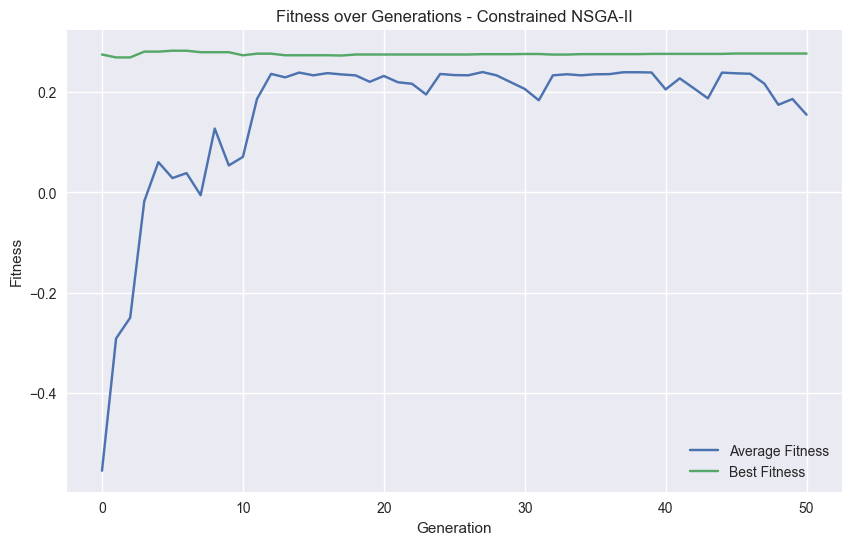

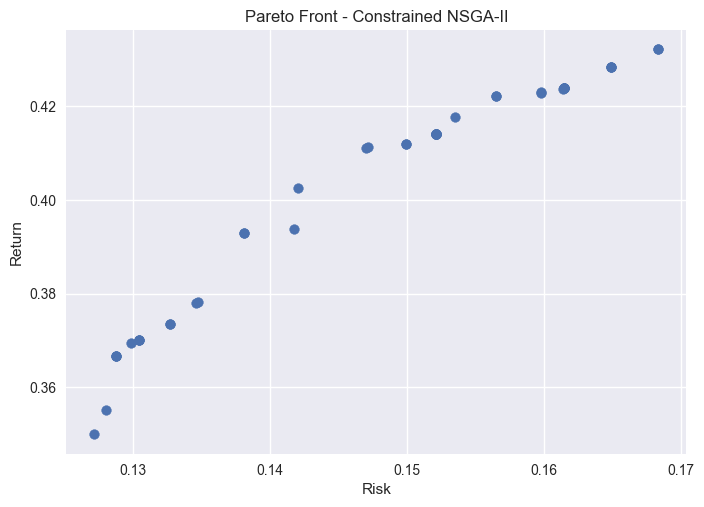

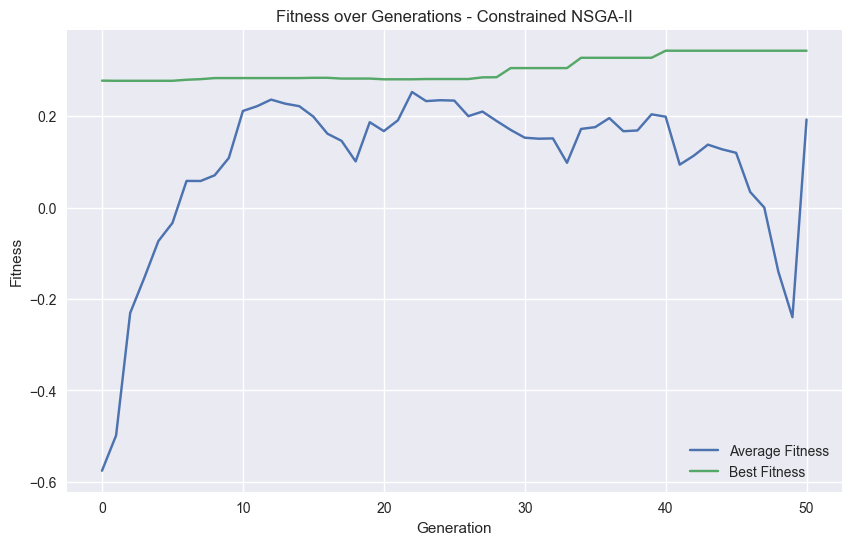

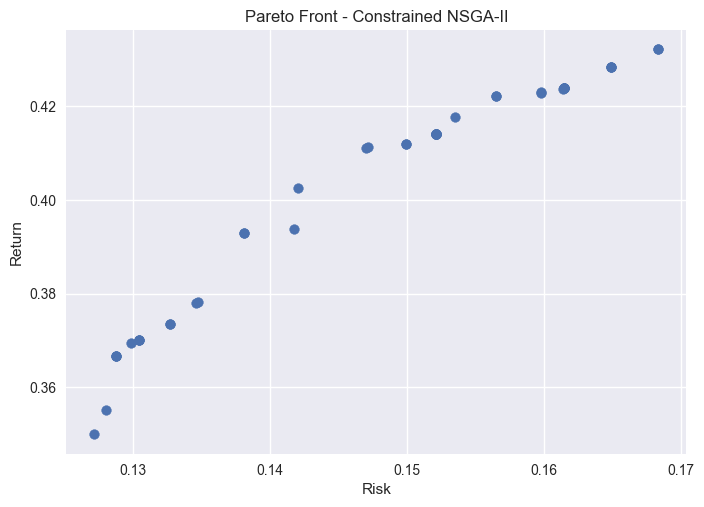

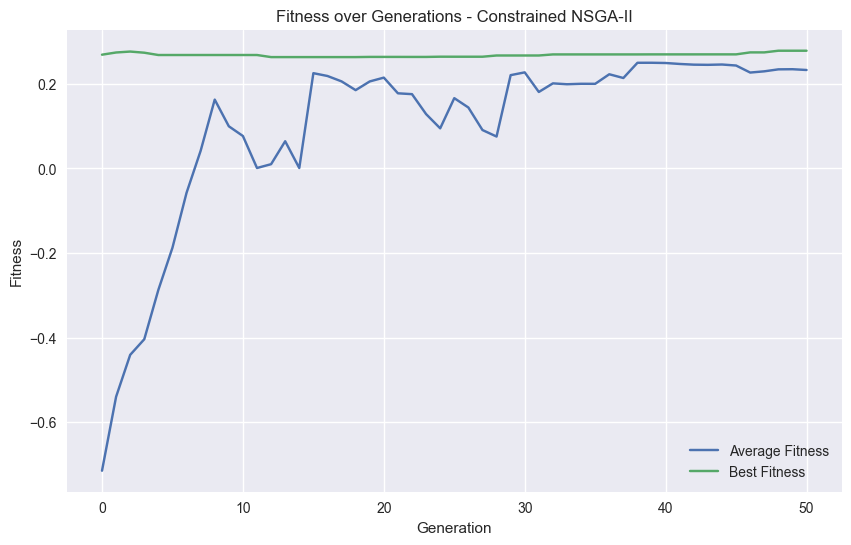

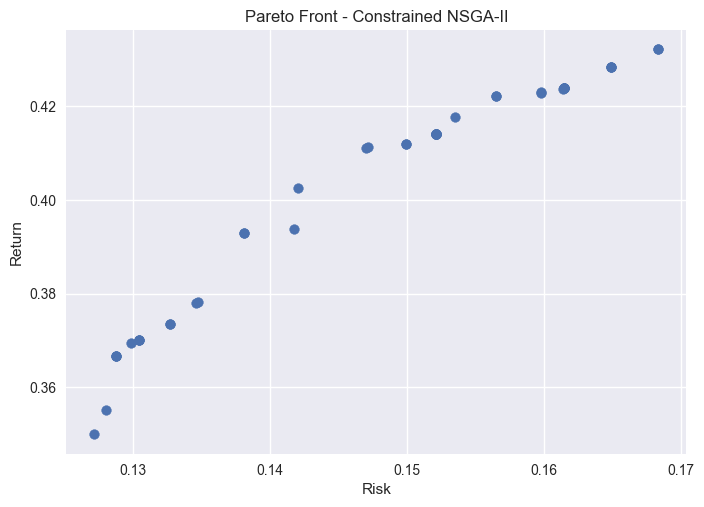

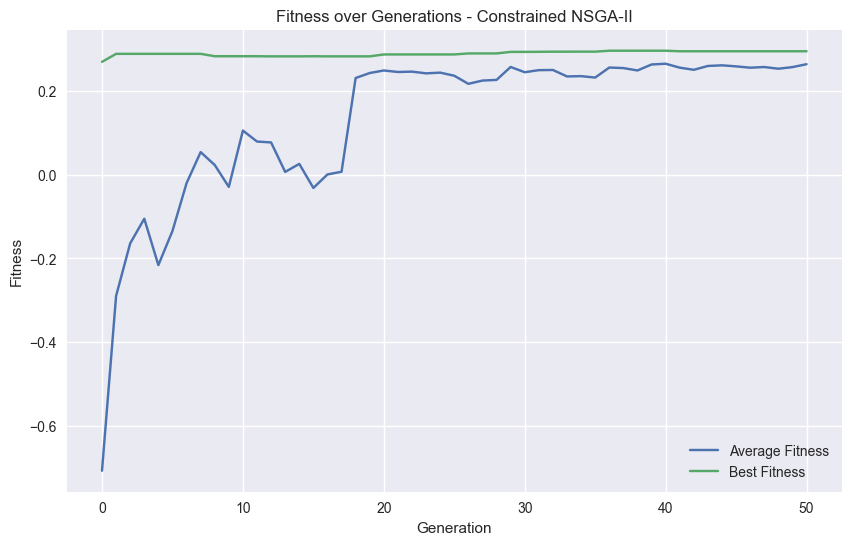

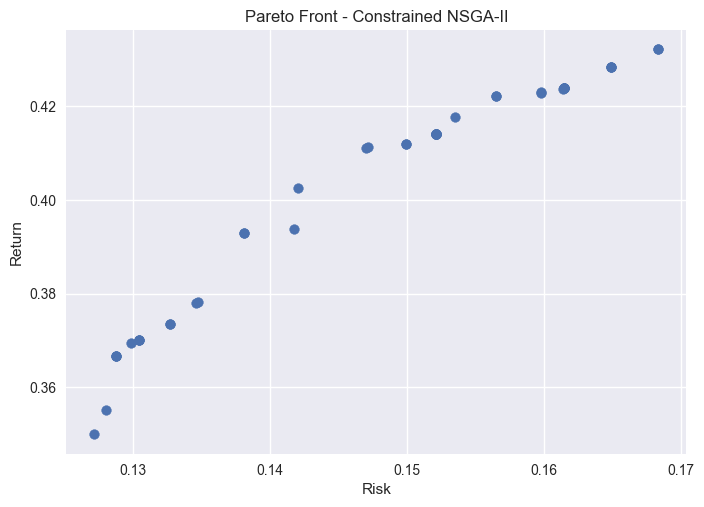

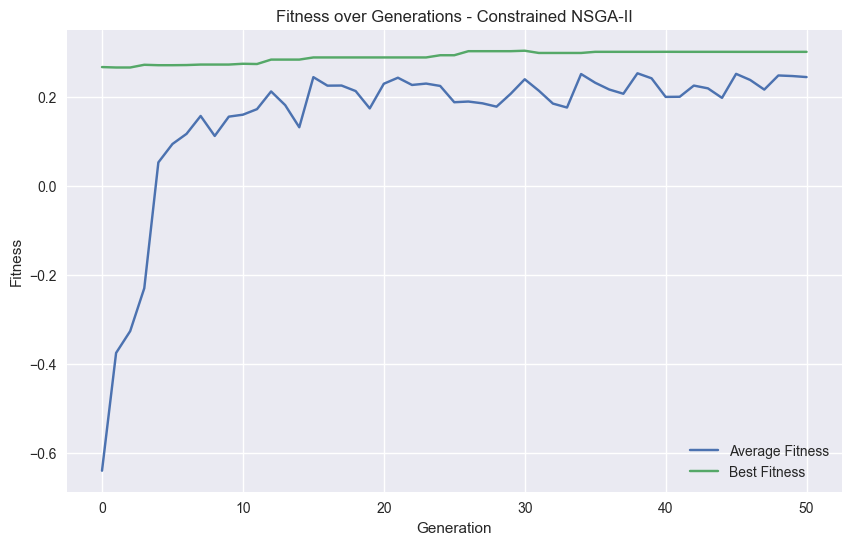

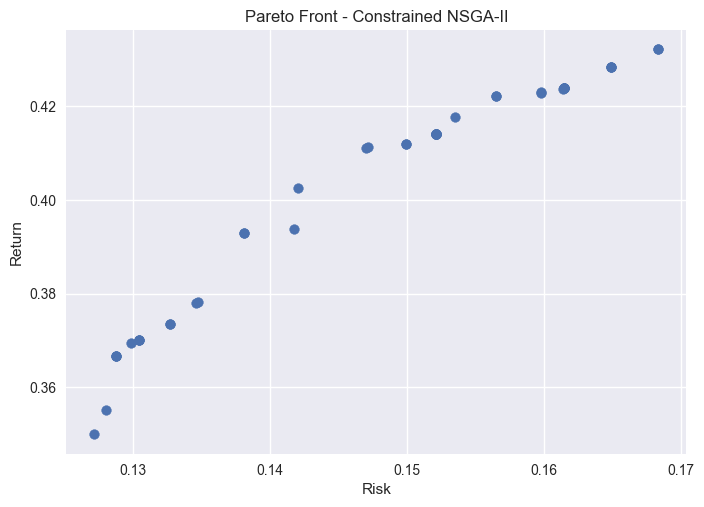

In [16]:
# Calculate average run time
avg_run_time = np.mean(all_runs_times)
print(f"Average run time: {avg_run_time:.2f} seconds")

for run in range(NUM_RUNS):
    gen = range(0, len(all_runs_stats[run]))
    avg_fitness = [np.mean(stat["avg"]) for stat in all_runs_stats[run]]  
    max_fitness = [np.mean(stat["max"]) for stat in all_runs_stats[run]] 

    plt.figure(figsize=(10, 6))
    plt.plot(gen, avg_fitness, label='Average Fitness')
    plt.plot(gen, max_fitness, label='Best Fitness')
    plt.title(f'Fitness over Generations - Constrained NSGA-II')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.show()

    min_return = 0.1 
    max_return = 1  
    min_risk = 0    
    max_risk = 0.5 

    # Extract returns and risks from the Pareto front
    pareto_front = tools.sortNondominated(pop, len(pop), first_front_only=True)[0]
    filtered_pareto_front = [ind for ind in pareto_front if min_return <= ind.fitness.values[0] <= max_return and min_risk <= ind.fitness.values[1] <= max_risk]

    filtered_returns = [ind.fitness.values[0] for ind in filtered_pareto_front]
    filtered_risks = [ind.fitness.values[1] for ind in filtered_pareto_front]

    plt.scatter(filtered_risks, filtered_returns)
    plt.title(f"Pareto Front - Constrained NSGA-II")
    plt.xlabel("Risk")
    plt.ylabel("Return")
    plt.show()

In [17]:
# Calculate Hypervolumes for all the runs
ref_point = np.array([0, 0.3])  # Adjust according to your objectives
hv = HV(ref_point=ref_point)

for run in range(NUM_RUNS):
    pop = all_runs_results[run]
    fitnesses = np.array([ind.fitness.values for ind in pop])
    hv_value = hv.do(fitnesses)
    print(f"Hypervolume for run {run + 1}: {hv_value}")

Hypervolume for run 1: 0.11763140506836839
Hypervolume for run 2: 0.2930068007775582
Hypervolume for run 3: 0.30057583358207024
Hypervolume for run 4: 0.0
Hypervolume for run 5: 0.11323917259514502


#### Exploring individual with maximum return

In [18]:

sector_counts = merged_df['Sector'].value_counts()

# Function to get the best individual (you need to define this based on your criteria)
def get_best_individual(pareto_front):
    # Example: Return the individual with the highest return (first fitness objective)
    return max(pareto_front, key=lambda ind: ind.fitness.values[0])

best_individual = get_best_individual(pareto_front)

sector_weightage = {sector: 0 for sector in sector_counts.index}
sector_ticker_count = {sector: 0 for sector in sector_counts.index}
for ticker, weight in best_individual:
    sector = tickers_sector.loc[tickers_sector['Name'] == ticker, 'Sector'].iloc[0]
    sector_weightage[sector] += weight
    sector_ticker_count[sector] += 1

for sector in sector_weightage:
    sector_weightage[sector] *= 100

radar_data = pd.DataFrame({
    'Sector': list(sector_weightage.keys()),
    'Weightage (%)': list(sector_weightage.values()),
    'Ticker Count': list(sector_ticker_count.values())
})

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=radar_data['Weightage (%)'],
    theta=radar_data['Sector'],
    fill='toself',
    name='Sector Weightage (%)'
))

fig.add_trace(go.Scatterpolar(
    r=radar_data['Ticker Count'],
    theta=radar_data['Sector'],
    fill='toself',
    name='Number of Tickers'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(radar_data['Weightage (%)'].max(), radar_data['Ticker Count'].max())]
        )),
    showlegend=True,
    title="Sector Analysis of Best Individual with respect to maximum return",
    width=700,  
    height=500 
)

fig.show()


#### Exploring individiual within specific volatility limits

In [19]:
def get_best_individual(pareto_front, max_volatility=0.13):
    # Filter individuals with volatility less than or equal to specified volatility
    filtered_individuals = [ind for ind in pareto_front if ind.fitness.values[1] <= max_volatility]

    # Return the individual with the highest return among the filtered individuals
    if filtered_individuals:
        return max(filtered_individuals, key=lambda ind: ind.fitness.values[0])
    else:
        return None  # Return None if no individual meets the volatility criterion

best_individual = get_best_individual(pareto_front)

if best_individual:
    print("Best individual with max return under given volatility:")
    print("Return:", best_individual.fitness.values[0])
    print("Volatility:", best_individual.fitness.values[1])
    print("Composition:", best_individual)
else:
    print("No individual meets the volatility criterion.")


Best individual with max return under given volatility:
Return: 0.36954588308664643
Volatility: 0.12982271184521482
Composition: [('ULTA', 0.028248061443735744), ('ORLY', 0.01642323334575117), ('GD', 0.012743902806992571), ('NOC', 0.021789229425030997), ('CBOE', 0.02398661723205912), ('PGR', 0.012957050310685982), ('IDXX', 0.026575106317463373), ('UNH', 0.01348296724017526), ('AAPL', 0.019446001782020043), ('SNPS', 0.03061271021822027), ('MNST', 0.019102163476640118), ('STZ', 0.029601636819133317), ('SBAC', 0.010723341201499715), ('SBAC', 0.02587345462078126), ('LNT', 0.026692224176323644), ('CMS', 0.024110368947715292), ('SLB', 0.02623296882650355), ('CVX', 0.027004047440775277), ('CHTR', 0.029860093696525414), ('CHTR', 0.021327779784868692), ('SHW', 0.030893511695365566), ('SHW', 0.029088967655256058), ('LMT', 0.013054567799964717), ('CBOE', 0.02311222414094949), ('EW', 0.01406451890031791), ('TSN', 0.0036165079315114393), ('ROST', 0.001466862015455705), ('IDXX', 0.02812948110629685)

In [20]:
# Extract sector information for this individual
sector_weightage = {sector: 0 for sector in sector_counts.index}
sector_ticker_count = {sector: 0 for sector in sector_counts.index}
for ticker, weight in best_individual:
    sector = tickers_sector.loc[tickers_sector['Name'] == ticker, 'Sector'].iloc[0]
    sector_weightage[sector] += weight
    sector_ticker_count[sector] += 1

for sector in sector_weightage:
    sector_weightage[sector] *= 100

radar_data = pd.DataFrame({
    'Sector': list(sector_weightage.keys()),
    'Weightage (%)': list(sector_weightage.values()),
    'Ticker Count': list(sector_ticker_count.values())
})

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=radar_data['Weightage (%)'],
    theta=radar_data['Sector'],
    fill='toself',
    name='Sector Weightage (%)'
))

fig.add_trace(go.Scatterpolar(
    r=radar_data['Ticker Count'],
    theta=radar_data['Sector'],
    fill='toself',
    name='Number of Tickers'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(radar_data['Weightage (%)'].max(), radar_data['Ticker Count'].max())]
        )),
    showlegend=True,
    title="Sector Analysis of an Individual within given volatility",
    width=700,  
    height=500 
)

fig.show()


#### Sharpe Ratio calculation

In [21]:
return_value = best_individual.fitness.values[0]
volatility = best_individual.fitness.values[1]
sharpe_ratio = (return_value - 0) / volatility

print("Sharpe Ratio:", sharpe_ratio)

Sharpe Ratio: 2.84654262597171


#### Visualization of HV over generation

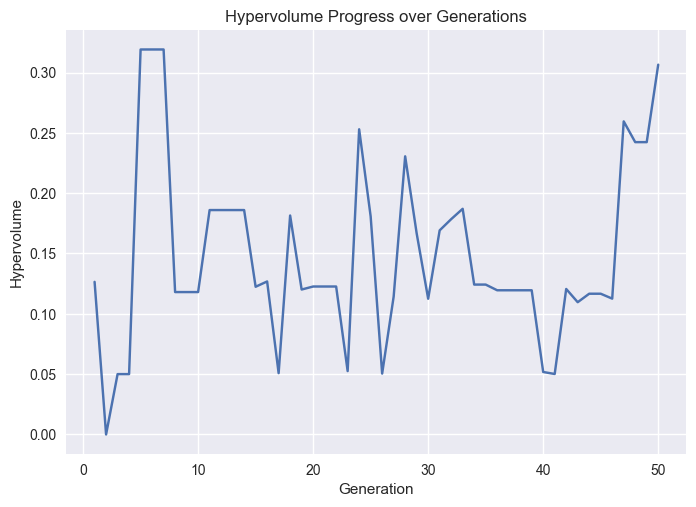

In [22]:
from pymoo.indicators.hv import HV

NUM_RUNS = 1
population_size = 50
ngen = 50

def run_NSGA2(population_size, ngen, toolbox):
    population = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    # Initialize hypervolume indicator
    ref_point = np.array([0.1, 0.2])
    hv_indicator = HV(ref_point=ref_point)
    hypervolume_values = []

    for gen in range(ngen):
        population = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, population)
        for fit, ind in zip(fits, population):
            ind.fitness.values = fit

        population = toolbox.select(population, k=len(population))

        # Extract Pareto front and calculate hypervolume
        pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]
        fitnesses = np.array([ind.fitness.values for ind in pareto_front])
        hv_value = hv_indicator(fitnesses)
        hypervolume_values.append(hv_value)

    return population, stats, hof, hypervolume_values

pop, logbook, hof, hypervolume_values = run_NSGA2(population_size, ngen, toolbox0)

# Plotting the hypervolume over generations
plt.plot(range(1, ngen+1), hypervolume_values)
plt.xlabel('Generation')
plt.ylabel('Hypervolume')
plt.title('Hypervolume Progress over Generations')
plt.show()

<center> Thank you!!